In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_pickle('src/full_data_cleaned.pkl')
first = pd.read_pickle('src/individual_videos.pkl')

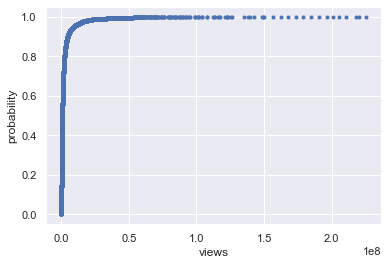

In [3]:
# plot ecdf of data
n = len(df.views)
x = np.sort(df.views)
y = np.arange(1, n+1) / n

plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('views')
plt.ylabel('probability');

Video views of trending videos are exponentially distributed

## Probability of a video to trend with under 100K views

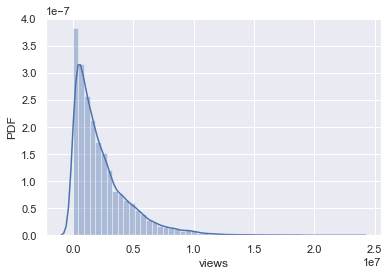

In [27]:
exp = np.random.exponential(mean_views, size=10000)

sns.distplot(exp)
plt.xlabel('views')
plt.ylabel('PDF');

In [34]:
prob = np.sum(exp <= 100000) / exp.size
print('Probability a trending will trend with under 100K views: ', prob)

Probability a trending will trend with under 100K views:  0.041


## Bootstrap sample mean --> views
- Find the mean of views
- Calculate the confidence interval in the potential range of the mean

In [38]:
def samp_func(data, func):
    bs_samp = np.random.choice(data, len(data))
    return func(bs_samp)

In [39]:
size = 10000
bs_means = np.empty(size)

for i in range(bs_means.size):
    bs_means[i] = samp_func(df.views, np.mean)

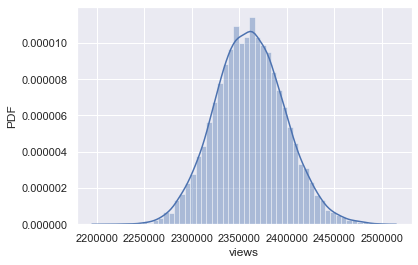

In [41]:
sns.distplot(bs_means, bins=50)
plt.xlabel('views')
plt.ylabel('PDF');

In [43]:
conf_int = np.percentile(bs_means, [2.5, 97.5])
print('The confidence interval of the average views of a trending video is: ', conf_int)

The confidence interval of the average views of a trending video is:  [2290006.77005024 2434659.44580084]


## Linear regression --> views x likes
- 95% CI, slope and intercept

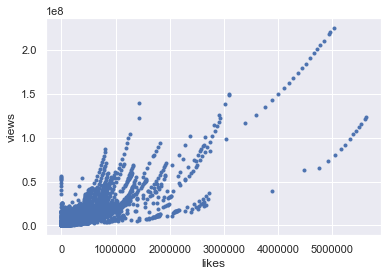

In [46]:
plt.plot(df.likes, df.views, marker='.', linestyle='none')
plt.xlabel('likes')
plt.ylabel('views');

In [56]:
ind = np.arange(len(df.views))

b_slopes = np.empty(1000)
b_intercepts = np.empty(1000)

for i in range(len(b_slopes)):
    b_samp = np.random.choice(ind, ind.size)
    b_likes = df.likes.iloc[b_samp]
    b_views = df.views.iloc[b_samp]
    samp_a, samp_b = np.polyfit(b_likes, b_views, 1)
    
    b_slopes[i] = samp_a
    b_intercepts[i] = samp_b

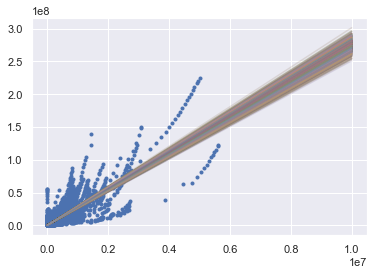

In [62]:
x = np.array([0, 10000000])

plt.plot(df.likes, df.views, marker='.', linestyle='none')

for i in range(len(b_slopes)):
    plt.plot(x, b_slopes[i]*x + b_intercepts[i], alpha=0.2)

In [63]:
conf_int_a = np.percentile(b_slopes, [2.5, 97.5])
conf_int_b = np.percentile(b_intercepts, [2.5, 97.5])

print('The confidence interval of the slope of the LLS regression is: ', conf_int_a)
print('The confidence interval of the intercept of the LLS regression is: ', conf_int_b)

The confidence interval of the slope of the LLS regression is:  [25.87210988 29.12575889]
The confidence interval of the intercept of the LLS regression is:  [221096.76236547 415239.29818473]
